In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Load the data

In [2]:
tasks_df = pd.read_csv("../assets/tasks.csv")
# tasks_df = tasks_df.loc[tasks_df["Task type"].isin(["Binary classification", "Multi-class classification", "Multi-label classification", "Regression"])]

In [3]:
models_df = pd.read_csv("../assets/models.csv")

In [4]:
results_paths = {
    "Open-source":  "./results/finetuning/{task_name}/{model_name}/test/test_results.json",    
    "Proprietary": "./results/text_generation/{task_name}/{model_name}/test_results.json",
    "Baseline": "./results/{model_name}/{task_name}/test/test_results.json"
}

In [5]:
metrics = {
    "Regression": "smape",
    "NER": "overall_f1",
    "MLM": "accuracy",
    "default": "f1_macro"
}

In [6]:
all_results = []

for i, task in tasks_df.iterrows():
    for j, model in models_df.iterrows():
        path_ = results_paths[model["Model type"]].format(
                task_name=task["Task ID"],
                model_name=model["Model ID"]
            )

        try:
            with open(path_, "r") as f:
                results = json.load(f)
                results = {k.replace("eval_", ""): v for k, v in results.items()}
            
            if task["Task type"] in metrics.keys():
                metric = metrics[task["Task type"]]
            else:
                metric = metrics["default"]

            row = task.to_dict() | model.to_dict()
            row["Score"] = results[metric]
            row["Epoch"] = results["epoch"] if "epoch" in results else None
            all_results.append(row)
        except FileNotFoundError:
            print("Error analyzing file in path:", path_)

all_results_df = pd.DataFrame(all_results)

# Calculating the inverse value of sMAPE (1-sMAPE)
all_results_df["Score"] = all_results_df.apply(lambda x: (1 - x["Score"]) if x["Task type"] == "Regression" else x["Score"], axis=1)

Error analyzing file in path: ./results/finetuning/se_entities/gpt2/test/test_results.json
Error analyzing file in path: ./results/finetuning/se_entities/gpt2-medium/test/test_results.json
Error analyzing file in path: ./results/finetuning/se_entities/gpt2-large/test/test_results.json
Error analyzing file in path: ./results/finetuning/se_entities/gpt2-xl/test/test_results.json
Error analyzing file in path: ./results/finetuning/se_entities/Llama-3.2-1B/test/test_results.json
Error analyzing file in path: ./results/finetuning/se_entities/Llama-3.2-3B/test/test_results.json
Error analyzing file in path: ./results/finetuning/se_entities/CodeLlama-7b-hf/test/test_results.json
Error analyzing file in path: ./results/finetuning/se_entities/starcoder2-3b/test/test_results.json
Error analyzing file in path: ./results/finetuning/se_entities/starcoder2-7b/test/test_results.json
Error analyzing file in path: ./results/text_generation/se_entities/gpt-4o-2024-08-06/test_results.json
Error analyzing 

In [7]:
all_results_df.shape

(410, 12)

In [8]:
all_results_df.sample(5)

,Task type,Task ID,Activity,Model ID,Model name,Model architecture,Model size,Number of parameters,Domain adaptation,Model type,Score,Epoch
260,Multi-label classification,comment_type_pharo,Development,bert-base-cased,BERT base,Encoder-only,Million params.,108310272.0,Generalist,Open-source,0.138495,1.200000
214,Multi-class classification,sentiment,Management,gpt2,GPT-2 small,Decoder-only,Million params.,124439808.0,Generalist,Open-source,0.776395,3.000000
196,Multi-class classification,question_quality,Management,t5-large,T5 large,Encoder-decoder,Million params.,737668096.0,Generalist,Open-source,0.850596,2.700000
325,Multi-label classification,review_aspect,Quality assurance,t5-base,T5 base,Encoder-decoder,Million params.,222903552.0,Generalist,Open-source,0.024555,1.263158
359,Multi-label classification,smell_doc,Quality assurance,codet5p-770m,CodeT5+ 770m,Encoder-decoder,Million params.,737639424.0,Domain-adapted,Open-source,0.409776,3.000000


### Visualize the data

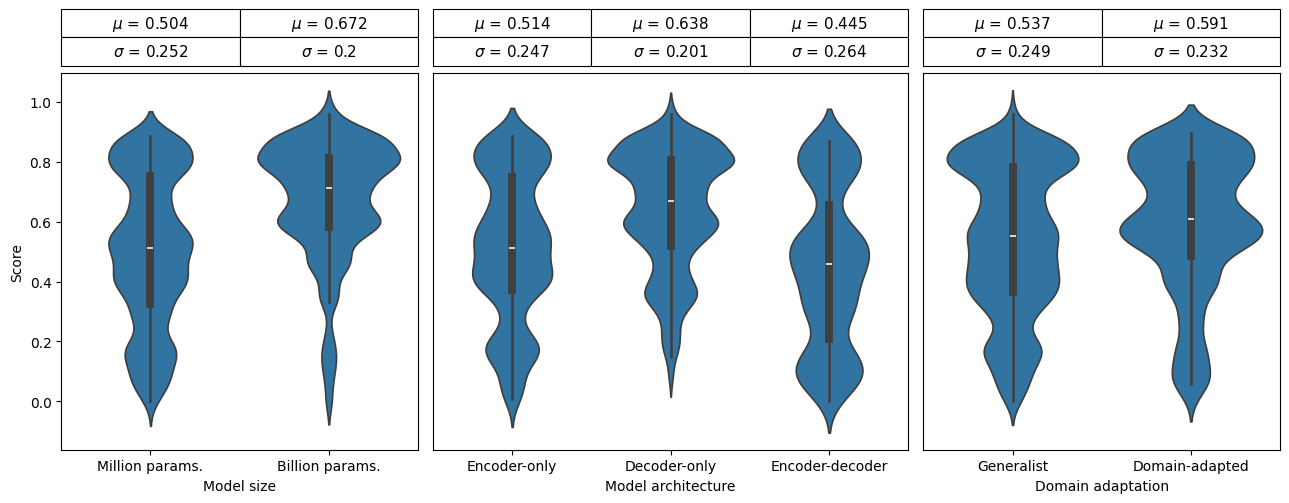

In [9]:
def plot_subplot(df, categorical_col, ax):
    sns.violinplot(data=df, x=categorical_col, y="Score", bw_adjust=0.5, ax=ax)

    stats_t = df.groupby(categorical_col).agg(
        mean=("Score", lambda x: "$\\mu$ = " + str(round(pd.Series.mean(x), 3))),
        std=("Score", lambda x: "$\\sigma$ = " + str(round(pd.Series.std(x), 3)))
    ).reindex([tick.get_text() for tick in ax.get_xticklabels()]).T

    table = ax.table(
        cellText=stats_t.values,
        loc="top",
        cellLoc="center",
        bbox=[0, 1.02, 1, 0.15]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)

    lw = ax.spines["bottom"].get_linewidth()
    for cell in table.get_celld().values():
        cell.set_linewidth(lw)

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(13, 5), gridspec_kw={'width_ratios': [0.3, 0.4, 0.3]})

plot_subplot(all_results_df, "Model size", axes[0])
plot_subplot(all_results_df, "Model architecture", axes[1])
plot_subplot(all_results_df, "Domain adaptation", axes[2])

for ax in axes[1:]:
    ax.tick_params(axis="y", which="both", left=False, labelleft=False)

plt.subplots_adjust(top=0.7, wspace=0.02)

plt.tight_layout()

plt.savefig("dists_by_drivers.pdf", format="pdf", bbox_inches="tight")

plt.show()

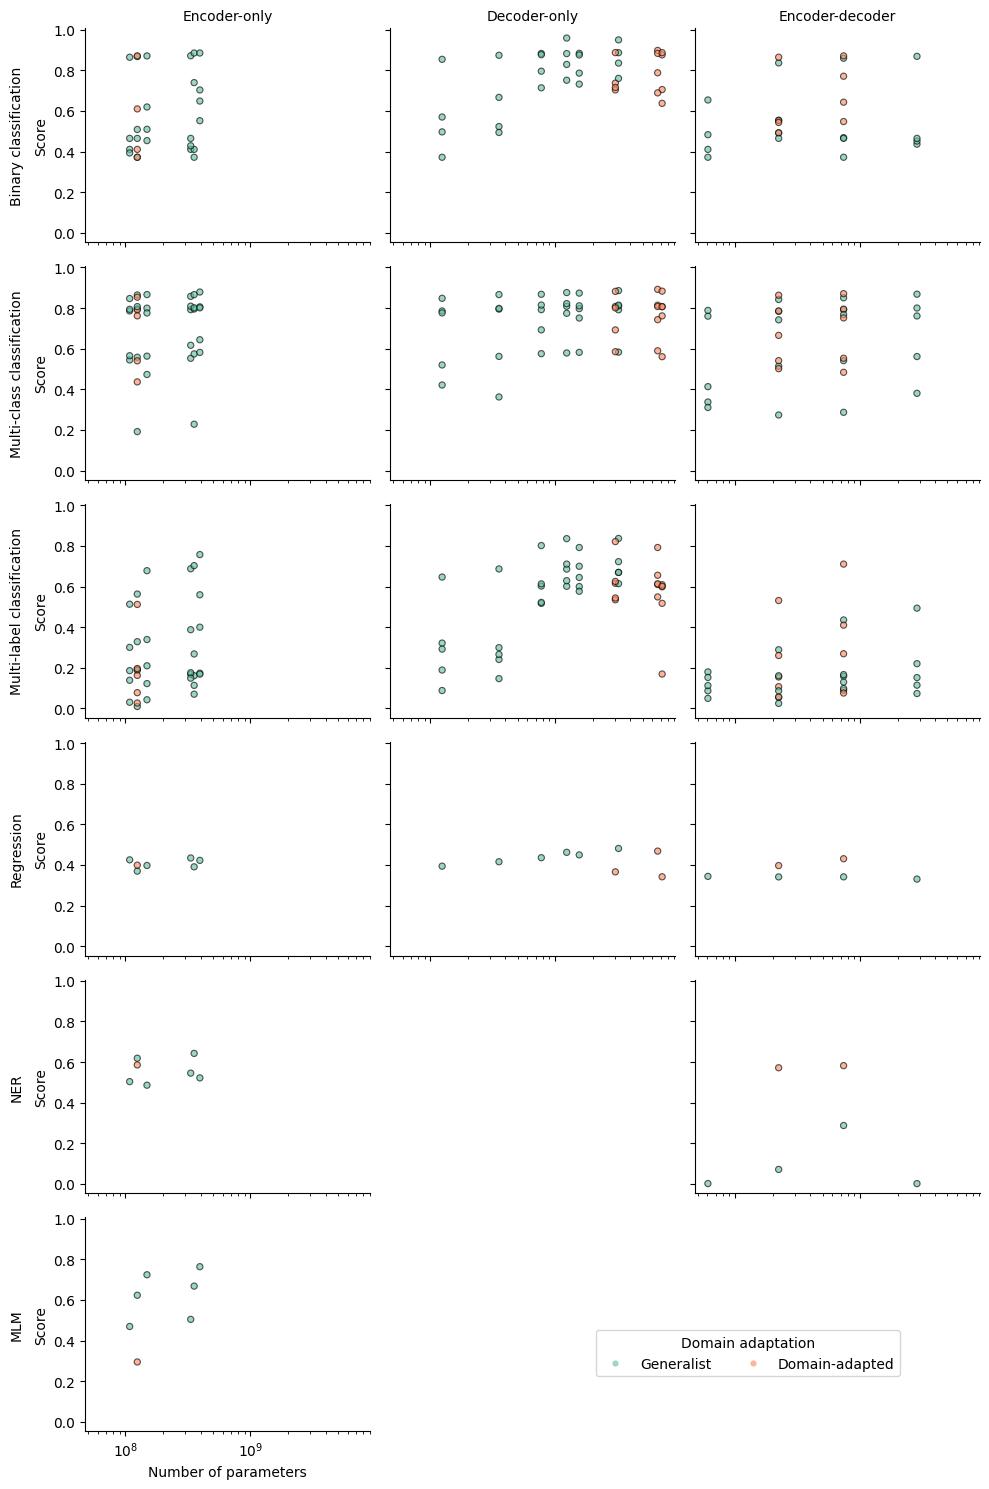

In [10]:
g = sns.relplot(
    data=all_results_df,
    x="Number of parameters",
    y="Score",
    hue="Domain adaptation",
    palette=["#66c2a5", "#fc8d62"],
    s=20,
    alpha=0.65,
    edgecolors="black",
    linewidths=0.8,
    col="Model architecture",
    row="Task type",
    kind="scatter"
)

g.set(xscale="log")

g.set_titles(col_template="{col_name}", row_template="{row_name}")
for i, _ in enumerate(g.row_names):
    for j, col_val in enumerate(g.col_names):
        ax = g.axes[i, j]
        if i == 0:
            ax.set_title(col_val, fontsize=10)
        else:
            ax.set_title("")

g.fig.subplots_adjust(hspace=0.1)
g.fig.set_size_inches(10, 15)

# Remove subplots with no data
for i, row_val in enumerate(g.row_names):
    for j, col_val in enumerate(g.col_names):
        # subset the DataFrame to see if there are any rows for this facet
        facet_df = all_results_df[
            (all_results_df["Task type"] == row_val)
            & (all_results_df["Model architecture"] == col_val)
        ]
        if facet_df.empty:
            ax_empty = g.axes[i, j]
            ax_empty.set_visible(False)

for i, row_val in enumerate(g.row_names):
    # Grab the leftmost Axes for this row
    ax_left = g.axes[i, 0]
    # Place text to the left of that axis, vertically centered
    ax_left.annotate(
        row_val,
        xy=(0, 0.5),               # use the axis’s left edge at half‐height
        xytext=(-ax_left.yaxis.labelpad - 40, 0),
        xycoords="axes fraction",  # (0,0) is lower‐left, (1,1) is upper‐right of that Axes
        textcoords="offset points",
        ha="right", va="center",
        fontsize=10,
        rotation=90
    )

sns.move_legend(
    g,
    loc="center",
    bbox_to_anchor=g.axes[-1, -1].get_position(),
    ncols=3,
    frameon=True
)

plt.tight_layout()

plt.savefig("dists_by_drivers_and_tasktype.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [11]:
df = all_results_df.loc[all_results_df["Model architecture"] == "Decoder-only"].groupby(["Model size", "Task type"])["Score"].mean().to_frame().reset_index().pivot(columns="Model size", index="Task type", values="Score")
df["diff"] = df["Billion params."] - df["Million params."]
df

Model size,Billion params.,Million params.,diff
Task type,,,
Binary classification,0.813982,0.676614,0.137367
Multi-class classification,0.766618,0.698621,0.067997
Multi-label classification,0.637976,0.415369,0.222608
Regression,0.427978,0.415030,0.012948


In [12]:
all_results_df.groupby(
    all_results_df["Task type"].isin(["MLM", "NER"]).replace({True: "50 epochs", False: "3 epochs"})
)["Epoch"].describe()

,count,mean,std,min,25%,50%,75%,max
Task type,,,,,,,,
3 epochs,320.0,2.395645,0.721838,1.2,1.532634,2.769231,3.00,3.0
50 epochs,20.0,21.850000,15.339234,0.0,8.500000,23.000000,32.75,50.0
